<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/LSTMSerieTemporalESP32/blob/main/%20treinomultvar/LSTMMultivariaveisMicrocontroller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SérieTemporal LSTM de Temperatura,Pressão e Umidade para Microcontrolador 

In [48]:
# Importing bibliotecas
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [49]:
### dados do Max plank Instituto de pesquisa 

zip_path = tf.keras.utils.get_file(origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip' , fname='jena_climate_2009_2016.csv.zip', extract=True)
print(zip_path)

csv_path = os.path.splitext(zip_path)

print(csv_path)

/root/.keras/datasets/jena_climate_2009_2016.csv.zip
('/root/.keras/datasets/jena_climate_2009_2016.csv', '.zip')


In [50]:
! ls /root/.keras/datasets/

jena_climate_2009_2016.csv  jena_climate_2009_2016.csv.zip


In [51]:
### criando dataset csv
import zipfile

zf = zipfile.ZipFile(zip_path)
df = pd.read_csv(zf.open('jena_climate_2009_2016.csv'))

df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [52]:
## features 

features_3 = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_3]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a04e4cd10>,
      dtype=object)

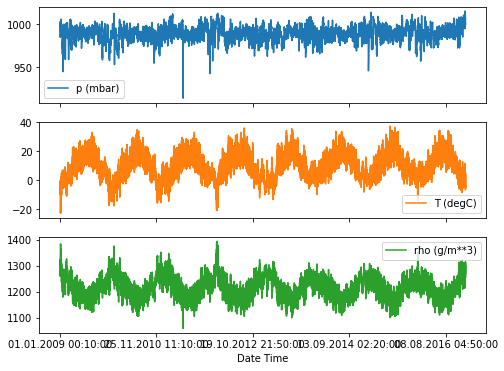

In [53]:
features.plot(subplots=True)

In [54]:
## divisão de teste  para média de janela móvel de série temporal simples
train_split = 300000
tf.random.set_seed(13)

In [55]:
### standardize data
dataset = features.values

data_mean = dataset[:train_split].mean(axis =0)

data_std = dataset[:train_split].std(axis = 0)

dataset = (dataset - data_mean)/data_std

In [56]:
### criar mutlivariate dataset

def mutlivariate_data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(dataset[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)

In [57]:
### função para criar passos de tempo
def create_time_steps(length):
  return list(range(-length,0))

### função para plotar dados de séries temporais

def plot_time_series(plot_data, delta , title):
  labels = ["Histórico" , 'Valor Futuro Verdadeiro' , 'Valor Predito Pelo Modelo']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt



In [58]:
### generate multivariate data

history = 720
future_target = 72
STEP = 6

x_train_ss , y_train_ss = mutlivariate_data(dataset , dataset[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = mutlivariate_data(dataset , dataset[:,1] , train_split , None , history ,
                                        future_target, STEP, single_step = True)

print(x_train_ss.shape , y_train_ss.shape)

(299280, 120, 3) (299280,)


In [59]:
## tensorflow dataset
batch_size = 256
buffer_size = 10000
train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [60]:

## treinamento da modelo LSTM
steps = 200
EPOCHS =10
single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32, input_shape = x_train_ss.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
single_step_model.add(tf.keras.layers.Dense(8))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mae')
modelo = single_step_model.fit(train_ss, epochs = EPOCHS , 
                                                  steps_per_epoch =steps, validation_data = val_ss,
                                                  validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 8s 30ms/step - loss: 0.4181 - val_loss: 0.2768
Epoch 2/10
200/200 [==============================] - 6s 28ms/step - loss: 0.2701 - val_loss: 0.2577
Epoch 3/10
200/200 [==============================] - 6s 28ms/step - loss: 0.2659 - val_loss: 0.2654
Epoch 4/10
200/200 [==============================] - 6s 29ms/step - loss: 0.2647 - val_loss: 0.2501
Epoch 5/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2315 - val_loss: 0.2443
Epoch 6/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2442 - val_loss: 0.2795
Epoch 7/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2438 - val_loss: 0.2704
Epoch 8/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2452 - val_loss: 0.2447
Epoch 9/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2517 - val_loss: 0.2558
Epoch 10/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2422 - val_lo

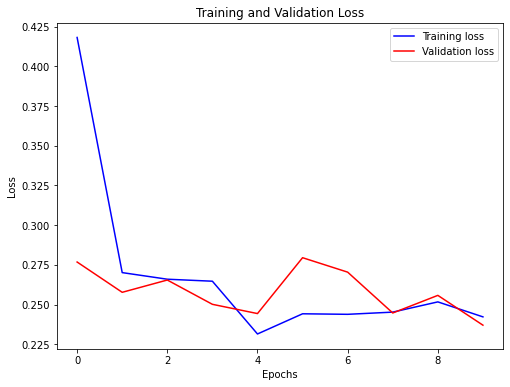

Final val loss:  [0.27676546573638916, 0.257698655128479, 0.26543116569519043, 0.250141441822052, 0.24431543052196503, 0.27948081493377686, 0.2703911066055298, 0.24468374252319336, 0.2557709813117981, 0.2370084971189499]


In [61]:
def visualize_loss(modelo, title):
    loss = modelo.history["loss"]
    val_loss = modelo.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print("Final val loss: ", val_loss)

visualize_loss(history, "Training and Validation Loss")

In [83]:
#sumário do modelo multiparametros
single_step_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 32)                4608      
                                                                 
 dense_36 (Dense)            (None, 16)                528       
                                                                 
 dense_37 (Dense)            (None, 8)                 136       
                                                                 
 dense_38 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


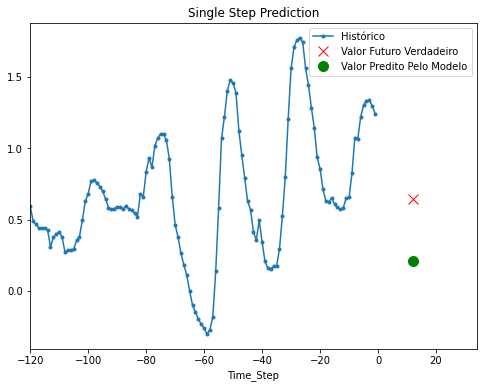

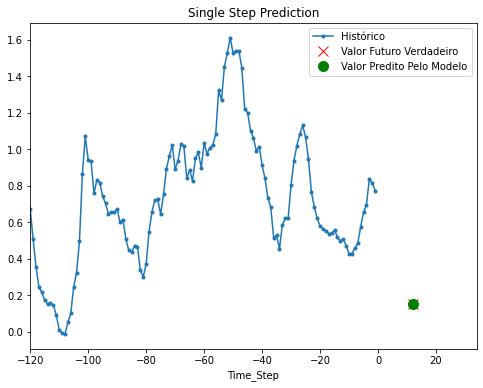

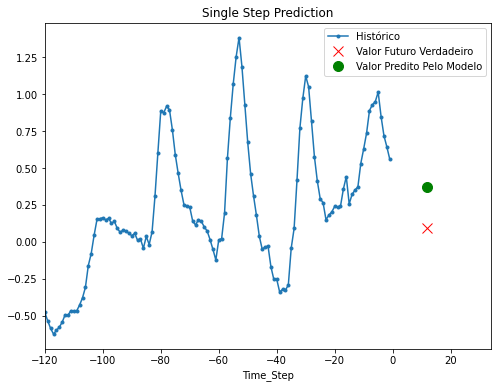

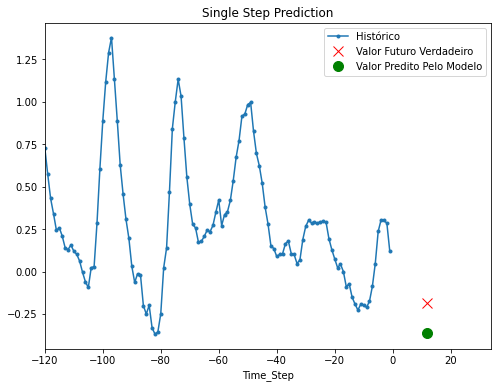

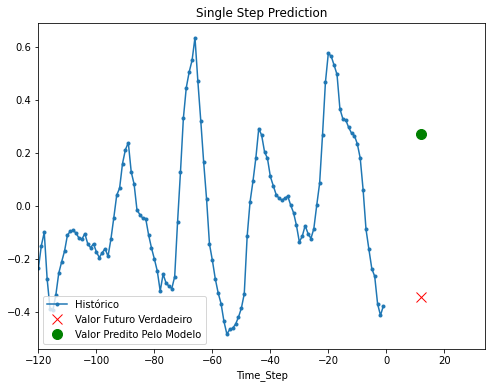

In [62]:
# plotar séries temporais e valores previstos

for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [63]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = mutlivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = mutlivariate_data(dataset, dataset[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(299280, 120, 3)
(299280, 72)


In [64]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

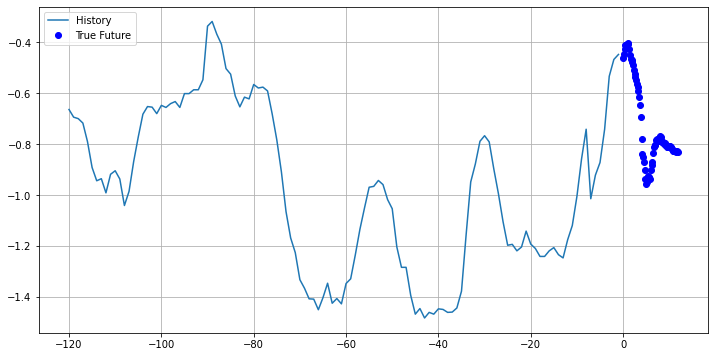

In [65]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [87]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 66s 311ms/step - loss: 0.4801 - val_loss: 0.2987
Epoch 2/10
200/200 [==============================] - 64s 320ms/step - loss: 0.3025 - val_loss: 0.2451
Epoch 3/10
200/200 [==============================] - 63s 313ms/step - loss: 0.2724 - val_loss: 0.2391
Epoch 4/10
200/200 [==============================] - 62s 311ms/step - loss: 0.2352 - val_loss: 0.1986
Epoch 5/10
200/200 [==============================] - 62s 312ms/step - loss: 0.1970 - val_loss: 0.1936
Epoch 6/10
200/200 [==============================] - 62s 311ms/step - loss: 0.2080 - val_loss: 0.2154
Epoch 7/10
200/200 [==============================] - 62s 308ms/step - loss: 0.2015 - val_loss: 0.2029
Epoch 8/10
200/200 [==============================] - 62s 312ms/step - loss: 0.1984 - val_loss: 0.2049
Epoch 9/10
200/200 [==============================] - 63s 316ms/step - loss: 0.2011 - val_loss: 0.1944
Epoch 10/10
200/200 [==============================] - 63s 315ms/step - l

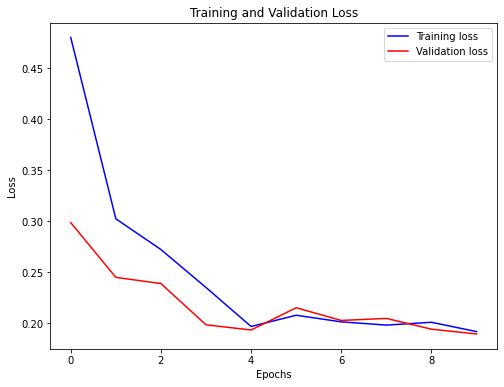

Final val loss:  [0.2987377643585205, 0.24511192739009857, 0.23906651139259338, 0.1986367255449295, 0.193572536110878, 0.21536926925182343, 0.20291908085346222, 0.20491857826709747, 0.19437174499034882, 0.18967105448246002]


In [88]:
def visualize_loss(history, title):
    loss = multi_step_history.history["loss"]
    val_loss = multi_step_history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print("Final val loss: ", val_loss)

visualize_loss(history, "Training and Validation Loss")

In [89]:
#sumário do modelo multiparametros
multi_step_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 120, 32)           4608      
                                                                 
 lstm_23 (LSTM)              (None, 16)                3136      
                                                                 
 dense_42 (Dense)            (None, 72)                1224      
                                                                 
Total params: 8,968
Trainable params: 8,968
Non-trainable params: 0
_________________________________________________________________


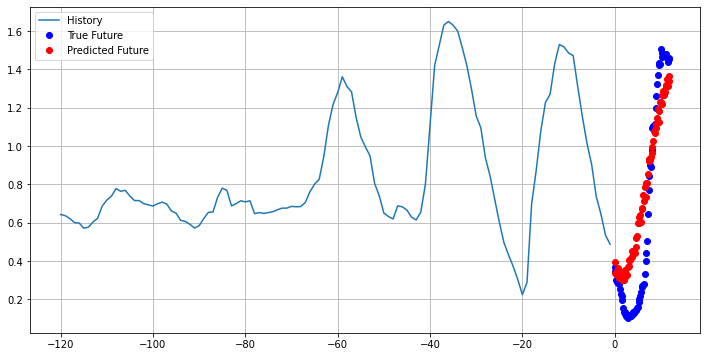

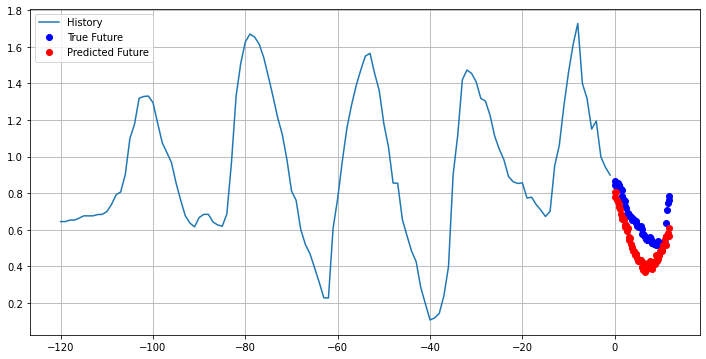

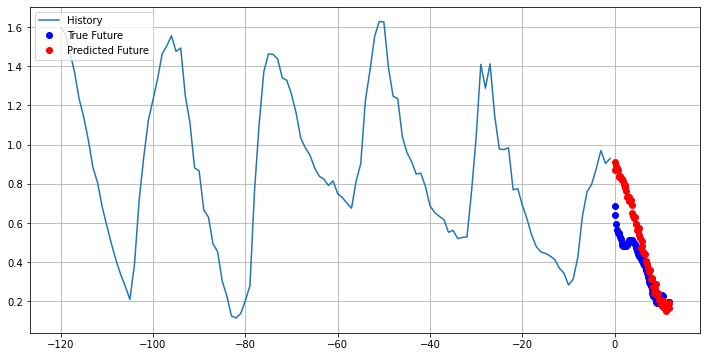

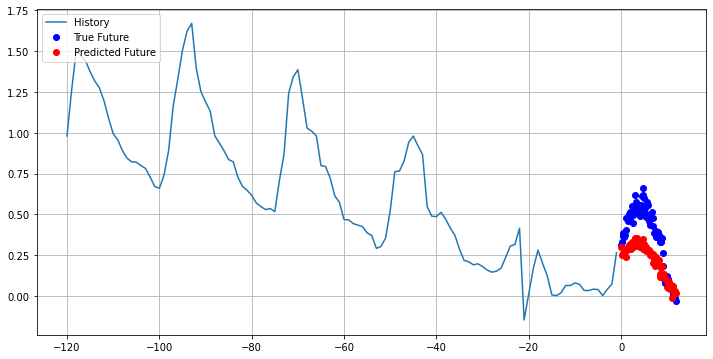

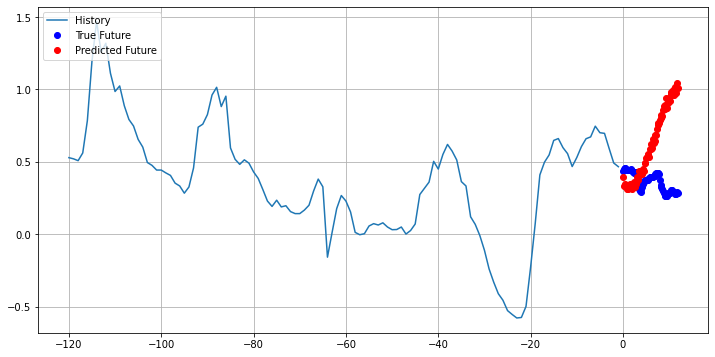

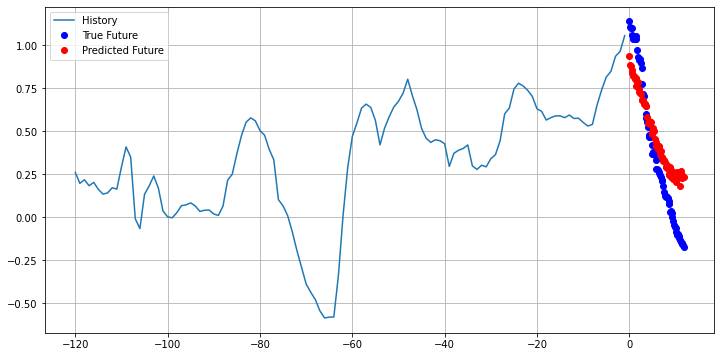

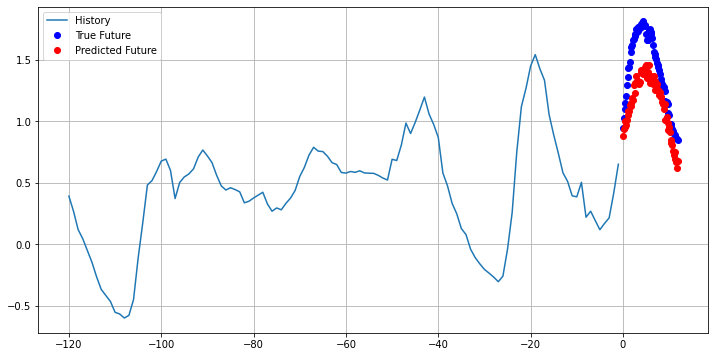

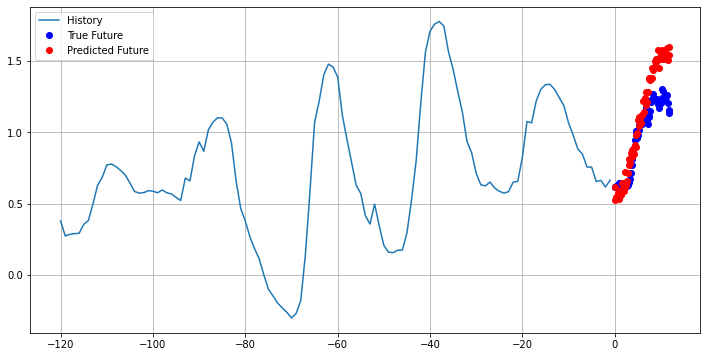

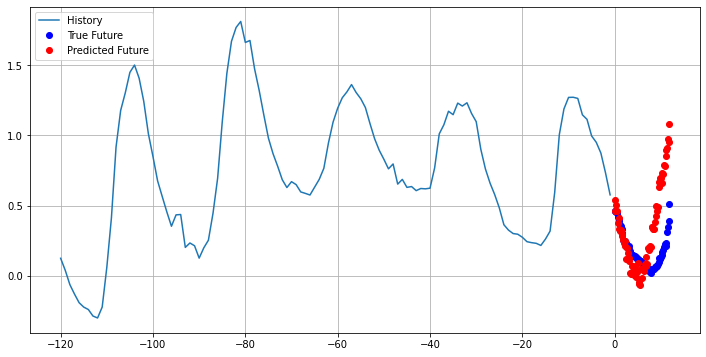

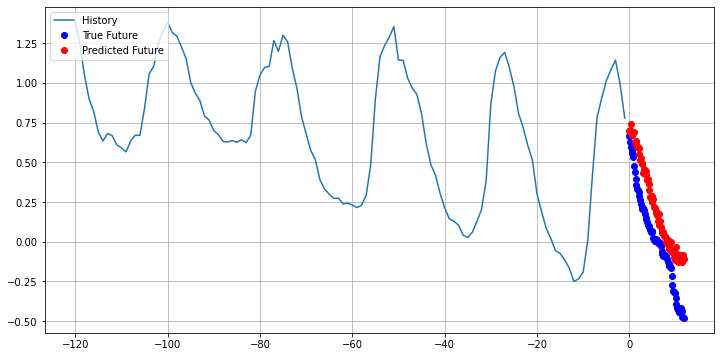

In [90]:
# previsão de algumas séries temporais
for x, y in val_data_multi.take(10):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

# Modelo Keras

In [91]:
multi_step_model.save('modelkeras.h5') 

In [92]:
MODEL_TFLITE = '/content/modelkeras.h5'
MODEL_TFLITE_MICRO = '/content/binarioh5.cc'

In [93]:
#gerar modelo para microcontrolador

# Instale xxd se não estiver disponível
!apt-get update && apt-get -qq install xxd
# Converter para um arquivo de origem C, ou seja, um modelo TensorFlow Lite for Microcontrollers
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Atualizar nomes de variáveis
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [94]:
# Imprima o arquivo de origem C
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x89, 0x48, 0x44, 0x46, 0x0d, 0x0a, 0x1a, 0x0a, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x08, 0x08, 0x00, 0x04, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff,
  0xff, 0xff, 0xff, 0xff, 0xa8, 0xac, 0x01, 0x00, 0x00, 0x00, 0x00, 0x00,
  0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x60, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x88, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0xa8, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x07, 0x00, 0x01, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x10, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x20, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x68, 0x01, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x54, 0x52, 0x45, 0x45, 0x00, 0x00, 0x01, 0x00,
  0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff,
  0xff, 0x

#Modelo Tensorflow Lite

In [95]:
#converter para TensorflowLite
# Converte the model to the TensorFlow Lite normal (sem quantização)
converter = tf.lite.TFLiteConverter.from_keras_model(multi_step_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

with open('modeltflite.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpyncmcusn/assets


INFO:tensorflow:Assets written to: /tmp/tmpyncmcusn/assets


In [96]:
MODEL_TFLITE = '/content/modeltflite.tflite'
MODEL_TFLITE_MICRO = '/content/binariotflite.cc'

In [97]:
#gerar modelo para microcontrolador

# Instale xxd se não estiver disponível
!apt-get update && apt-get -qq install xxd
# Converter para um arquivo de origem C, ou seja, um modelo TensorFlow Lite for Microcontrollers
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Atualizar nomes de variáveis
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

In [98]:
# Imprima o arquivo de origem C
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x00, 0x00, 0x64, 0x00, 0x00, 0x00, 0x68, 0x03, 0x00, 0x00,
  0x74, 0x00, 0x00, 0x00, 0x18, 0x03, 0x00, 0x00, 0x8c, 0x02, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x14, 0xb3, 0x00, 0x00, 0x68, 0xb2, 0x00, 0x00,
  0xac, 0xb1, 0x00, 0x00, 0x00, 0xb1, 0x00, 0x00, 0x70, 0xb0, 0x00, 0x00,
  0x84, 0xaf, 0x00, 0x00, 0x58, 0xae, 0x00, 0x00, 0xec, 0xac, 0x00, 0x00,
  0x90, 0xab, 0x00, 0x00, 0xa8, 0xa1, 0x00, 0x00, 0x48, 0x9e, 0x00, 0x00,
  0xb4, 0x52, 0x00, 0x00, 0x14, 0x51, 0x00, 0x00, 0x50, 0x4e, 0x00, 0x00,
  0xb4, 0x4d, 0x00, 0x00, 0xd4, 0x4c, 0x00, 0x00, 0xe4, 0x4b, 0x00, 0x00,
  0x2c, 0x49, 0x00, 0x00, 0x08, 0x0a, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00,
  0xe4, 0x9f, 0x00, 0x00, 0x80, 0x9d, 0x00, 0x00, 0x5c, 0x47, 0x00, 0x00,
  0xfc, 0x

In [99]:
# Atualiza a forma de entrada do modelo para um tamanho fixo de 8 bits, conforme ditado pelos requisitos de modelos de microcontroladores
batch_size = 1
multi_step_model.input.set_shape((batch_size,) + multi_step_model.input.shape[1:])
multi_step_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 120, 32)           4608      
                                                                 
 lstm_23 (LSTM)              (None, 16)                3136      
                                                                 
 dense_42 (Dense)            (None, 72)                1224      
                                                                 
Total params: 8,968
Trainable params: 8,968
Non-trainable params: 0
_________________________________________________________________


In [100]:
# Converte o modelo para TensorFlow Lite  com quantizatização
converter = tf.lite.TFLiteConverter.from_keras_model(multi_step_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflitemodoquant = converter.convert()
# Save the model to disk
open("tflitemodoquant.tflite", "wb").write(tflitemodoquant)

INFO:tensorflow:Assets written to: /tmp/tmpe023g7jf/assets


INFO:tensorflow:Assets written to: /tmp/tmpe023g7jf/assets


31552

In [101]:
MODEL_TFLITE = '/content/tflitemodoquant.tflite'
MODEL_TFLITE_MICRO = '/content/binariotflitequant.cc'

In [102]:
#gerar modelo para microcontrolador

# Instale xxd se não estiver disponível
!apt-get update && apt-get -qq install xxd
# Converter para um arquivo de origem C, ou seja, um modelo TensorFlow Lite for Microcontrollers
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Atualizar nomes de variáveis
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [103]:
# Imprima o arquivo de origem C
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x28, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x14, 0x00, 0x20, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x18, 0x00, 0x1c, 0x00, 0x14, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0xfc, 0x79, 0x00, 0x00, 0x5c, 0x53, 0x00, 0x00, 0x44, 0x53, 0x00, 0x00,
  0xac, 0x00, 0x00, 0x00, 0x7c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x2a, 0x92, 0xff, 0xff,
  0x44, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0xd4, 0x93, 0xff, 0xff, 0x08, 0x00, 0x00, 0x00,
  0x23, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x34, 0x32, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x

In [104]:
keras_model_size = os.path.getsize("/content/modelkeras.h5")
print("O modelo keras tem %d bytes" % keras_model_size)
tflite_model_size = os.path.getsize("/content/modeltflite.tflite")
print("O modelo  tensorflow lite tem %d bytes" % tflite_model_size)
quant_model_size = os.path.getsize("/content/tflitemodoquant.tflite")
print("O modelo quantizado tem %d bytes" % quant_model_size)
#difference = basic_model_size - quantized_model_size
#print("Difference is %d bytes" % difference)

O modelo keras tem 109736 bytes
O modelo  tensorflow lite tem 53540 bytes
O modelo quantizado tem 31552 bytes
